In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Input,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
import itertools 
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.simplefilter(action='ignore', category = FutureWarning)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Number of GPUs Available',len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs Available 1


In [3]:
train_path = 'Test_Technique_Image/Neuroflux_disorder_splitted/train'
valid_path = 'Test_Technique_Image/Neuroflux_disorder_splitted/val'
test_path = 'Test_Technique_Image/Neuroflux_disorder_splitted/test'

In [4]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

valAug = ImageDataGenerator(
    rescale=1 / 255.0)
testAug = ImageDataGenerator(
    rescale=1 / 255.0)

In [5]:
train_batches = trainAug.flow_from_directory(directory=train_path, class_mode="categorical",target_size=(256,256), color_mode="rgb", classes=['EO','IO','IPTE','LO','PTE'], shuffle=True,batch_size=32)
valid_batches = valAug.flow_from_directory(directory=valid_path,class_mode="categorical",target_size=(256,256), color_mode="rgb", classes=['EO','IO','IPTE','LO','PTE'], batch_size=32,shuffle=False)
test_batches = testAug.flow_from_directory(directory=test_path, class_mode="categorical",target_size=(256,256), color_mode="rgb", classes=['EO','IO','IPTE','LO','PTE'], batch_size=32 , shuffle=False)

Found 899 images belonging to 5 classes.
Found 256 images belonging to 5 classes.
Found 133 images belonging to 5 classes.


In [6]:
totalTrain = len(list(paths.list_images(train_path)))
print(totalTrain)
totalVal = len(list(paths.list_images(valid_path)))
print(totalVal)
totalTest = len(list(paths.list_images(test_path)))
print(totalTest)

899
256
133


In [7]:
trainLabels = train_batches.classes

In [8]:
trainLabels = to_categorical(trainLabels)

In [9]:
trainLabels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [10]:
classTotals = trainLabels.sum(axis=0)

In [11]:
classTotals

array([161.,  50., 119., 168., 401.], dtype=float32)

In [12]:
classWeight = dict()

In [13]:
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [14]:
classWeight

{0: 2.4906833, 1: 8.02, 2: 3.3697479, 3: 2.3869047, 4: 1.0}

In [16]:
BATCH_SIZE = 32
epochs = 60

In [17]:
imgs, labels = next(train_batches)

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

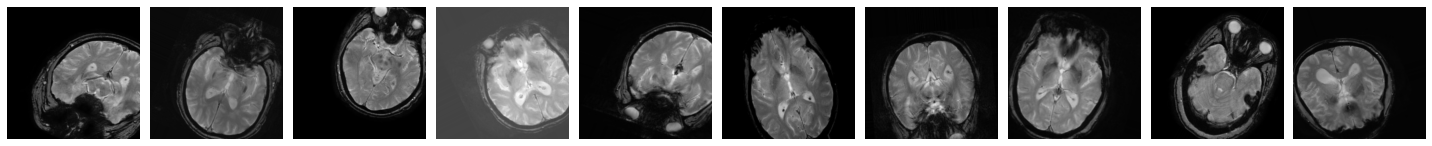

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [19]:
plotImages(imgs)
print(labels)

In [53]:
baseModel = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(256, 256, 3)))

In [54]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(500, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

In [55]:
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

In [56]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [57]:
for layer in baseModel.layers:
	layer.trainable = False

In [58]:
filepath = "Model_1.h5"

In [59]:
checkpoint = ModelCheckpoint ( filepath , monitor = 'val_acc', verbose =1, mode = 'max' )

In [60]:
callbacks_list = [ checkpoint ]

In [61]:
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [62]:
print("[INFO] training head...")
H = model.fit(
	x=train_batches,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valid_batches,
	validation_steps=totalVal // BATCH_SIZE,
    class_weight=classWeight,
	epochs=epochs,
    callbacks = callbacks_list)

[INFO] training head...
Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 15.0859 - accuracy: 0.1857
Epoch 00001: saving model to Model_1.h5
28/28 [==============================] - 11s 408ms/step - loss: 15.0859 - accuracy: 0.1857 - val_loss: 1.6377 - val_accuracy: 0.1914
Epoch 2/60
28/28 [==============================] - ETA: 0s - loss: 3.7579 - accuracy: 0.1949
Epoch 00002: saving model to Model_1.h5
28/28 [==============================] - 12s 417ms/step - loss: 3.7579 - accuracy: 0.1949 - val_loss: 1.6102 - val_accuracy: 0.1484
Epoch 3/60
28/28 [==============================] - ETA: 0s - loss: 3.5577 - accuracy: 0.1246
Epoch 00003: saving model to Model_1.h5
28/28 [==============================] - 12s 444ms/step - loss: 3.5577 - accuracy: 0.1246 - val_loss: 1.6088 - val_accuracy: 0.1328
Epoch 4/60
28/28 [==============================] - ETA: 0s - loss: 3.5827 - accuracy: 0.2295
Epoch 00004: saving model to Model_1.h5
28/28 [==============================] - 1

Epoch 32/60
28/28 [==============================] - ETA: 0s - loss: 3.5443 - accuracy: 0.4418
Epoch 00032: saving model to Model_1.h5
28/28 [==============================] - 13s 477ms/step - loss: 3.5443 - accuracy: 0.4418 - val_loss: 1.5889 - val_accuracy: 0.4375
Epoch 33/60
28/28 [==============================] - ETA: 0s - loss: 3.5499 - accuracy: 0.4498
Epoch 00033: saving model to Model_1.h5
28/28 [==============================] - 14s 498ms/step - loss: 3.5499 - accuracy: 0.4498 - val_loss: 1.6094 - val_accuracy: 0.3320
Epoch 34/60
28/28 [==============================] - ETA: 0s - loss: 3.5497 - accuracy: 0.4210
Epoch 00034: saving model to Model_1.h5
28/28 [==============================] - 14s 491ms/step - loss: 3.5497 - accuracy: 0.4210 - val_loss: 1.6152 - val_accuracy: 0.3164
Epoch 35/60
28/28 [==============================] - ETA: 0s - loss: 3.5504 - accuracy: 0.4429
Epoch 00035: saving model to Model_1.h5
28/28 [==============================] - 14s 493ms/step - loss: 

In [71]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4])

In [72]:
predictions = model.predict(test_batches)

In [73]:
np.round(predictions)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0.

In [74]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [75]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [76]:
test_batches.class_indices

{'EO': 0, 'IO': 1, 'IPTE': 2, 'LO': 3, 'PTE': 4}

Confusion matrix, without normalization
[[ 0  0  0  0 24]
 [ 0  0  0  0  8]
 [ 1  0  3  0 14]
 [ 0  0  0  0 24]
 [ 0  0  0  0 59]]


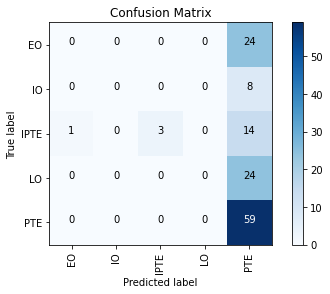

In [77]:
cm_plot_labels = ['EO','IO','IPTE','LO','PTE']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [78]:
print(classification_report(test_batches.classes,np.argmax(predictions,axis=-1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00         8
           2       1.00      0.17      0.29        18
           3       0.00      0.00      0.00        24
           4       0.46      1.00      0.63        59

    accuracy                           0.47       133
   macro avg       0.29      0.23      0.18       133
weighted avg       0.34      0.47      0.32       133



C:\Users\brahi\anaconda3\envs\PFE\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brahi\anaconda3\envs\PFE\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brahi\anaconda3\envs\PFE\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


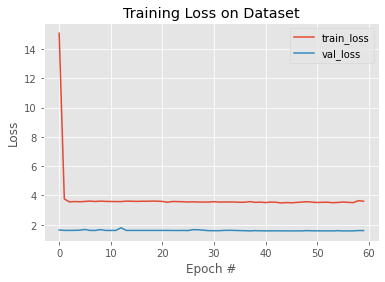

In [79]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

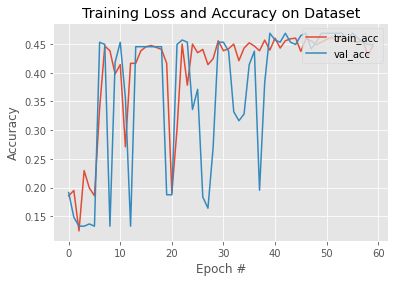

In [80]:
# plot the training accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")